# Tutorial Assignment 2

In [638]:
import os

import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.metrics  # use existing libraries!

import scipy.sparse

import tqdm

import matplotlib.pyplot as plt

import graphviz
import IPython.display
import ipywidgets
import sklearn.ensemble 
import yaml

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.mixture import GaussianMixture

In [559]:
# score function: binary cross entropy loss
def score_yp(y, p): # y, p are numpy arrays
    return sklearn.metrics.log_loss(y, p)

In [560]:
# score wrapper, for data frames. we need this when using the `truth` data frame
def score(x, y): # x, y are data frames
    xy = pd.merge(x, y, on=["customer", "product", "week"])
    assert xy.shape[0] == x.shape[0]
    return score_yp(xy["y"].values, xy["probability"].values)

## Input

In [561]:
# the path that contains the data
path = os.path.expandvars("/Users/vlad/Learning-from-Big-Data-Module-2/Assignment 2/")

# note that you don't have access to the truth data set
path_truth = os.path.expandvars("/Users/vlad/Learning-from-Big-Data-Module-2/Assignment 2/")

In [562]:
# INPUT
training_week = 88  # for model training
validation_week = 89  # for model and baseline validation
test_week = 90  # for the final prediction (one week in the future, beyond our data)
target_customers = list(range(2000))
target_products = list(range(250))

## Load data

In [563]:
#baskets = pd.read_parquet(f"{path}/baskets-s.parquet")
# we only keep the 2000 customers required for the test set
# a complex model might require more data, e.g., see Boosted Tree model in Gabel & Timoshenko (2021)
#baskets = baskets[baskets["customer"]<2000]
#baskets.head()

In [564]:
#start
baskets = pd.read_parquet(f"{path}/baskets-s.parquet")
# we only keep the the customers required for the test set
# a complex model might require more data, e.g., see Boosted Tree model in Gabel & Timoshenko (2021)
baskets = baskets[baskets["customer"].isin(target_customers)]
baskets

,week,customer,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592
...,...,...,...,...
68091869,89,1999,144,562
68091870,89,1999,158,566
68091871,89,1999,192,549
68091872,89,1999,213,592


In [565]:
baskets.describe()

,week,customer,product,price
count,1.378720e+06,1.378720e+06,1.378720e+06,1.378720e+06
mean,4.447746e+01,9.972110e+02,1.250727e+02,5.843381e+02
std,2.597662e+01,5.762501e+02,6.970123e+01,9.743281e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,2.340000e+02
25%,2.200000e+01,4.990000e+02,6.600000e+01,5.060000e+02
50%,4.400000e+01,9.930000e+02,1.230000e+02,5.790000e+02
75%,6.700000e+01,1.496000e+03,1.890000e+02,6.540000e+02
max,8.900000e+01,1.999000e+03,2.490000e+02,8.370000e+02


In [566]:
baskets["basket"] = baskets["customer"] * 1000000 + baskets["week"]

In [567]:
# create a (binary) space matrix that indicates whether a basket (row) contains a product (col)
# co-occurrences are the dot produdct of this basket-product matrix
# return data frame
def get_co_occurrences(x, variable_basket="basket", variable_product="product"):
    row = x[variable_basket].values
    col = x[variable_product].values
    dim = (x[variable_basket].max() + 1, x[variable_product].max() + 1)

    basket_product_table = scipy.sparse.csr_matrix(
        (np.ones(len(row), dtype=int), (row, col)), shape=dim
    )
    co_occurrences_sparse = basket_product_table.T.dot(basket_product_table).tocoo()
    co_occurrences_df = pd.DataFrame(
        {
            "product_1": co_occurrences_sparse.row,
            "product_2": co_occurrences_sparse.col,
            "co-occurrence": co_occurrences_sparse.data,
        }
    )
    return co_occurrences_df

In [568]:
co_occurrences = get_co_occurrences(baskets)
co_occurrences

,product_1,product_2,co-occurrence
0,208,0,15
1,233,0,1
2,59,0,4
3,71,0,6
4,70,0,12
...,...,...,...
60177,184,249,296
60178,130,249,262
60179,76,249,2028
60180,67,249,595


In [569]:
print(co_occurrences.loc[0].at["product_2"])

print(co_occurrences.loc[0].at["product_1"])

print(co_occurrences.loc[0].at["co-occurrence"])

co_oc_mat=np.zeros((250, 250))

sec=co_occurrences.loc[0].at["product_2"]
co_oc_mat[sec][sec]=5
co_oc_mat

0
208
15


array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [570]:
co_oc_mat=np.zeros((250, 250))

for index, prod_1 in co_occurrences['product_1'].items():
    prod_2 = co_occurrences.loc[index].at["product_2"]
    co_oc_mat[prod_1][prod_2] = co_occurrences.loc[index].at["co-occurrence"]

co_oc_mat

array([[2.9750e+03, 0.0000e+00, 0.0000e+00, ..., 9.0000e+00, 9.0000e+01,
        4.3200e+02],
       [0.0000e+00, 1.0153e+04, 0.0000e+00, ..., 4.0000e+01, 5.1500e+02,
        3.5100e+02],
       [0.0000e+00, 0.0000e+00, 2.8980e+03, ..., 4.9000e+01, 2.3400e+02,
        1.2200e+02],
       ...,
       [9.0000e+00, 4.0000e+01, 4.9000e+01, ..., 1.2670e+03, 0.0000e+00,
        0.0000e+00],
       [9.0000e+01, 5.1500e+02, 2.3400e+02, ..., 0.0000e+00, 1.1548e+04,
        0.0000e+00],
       [4.3200e+02, 3.5100e+02, 1.2200e+02, ..., 0.0000e+00, 0.0000e+00,
        1.1607e+04]])

In [571]:
np.fill_diagonal(co_oc_mat, 0) 
# fill diagonal with "0" since it the information about the product occurs in the basket does not give us any relevant info.

dfmax, dfmin = co_oc_mat.max(), co_oc_mat.min()
co_oc_mat_norm = (co_oc_mat - dfmin)/(dfmax - dfmin)

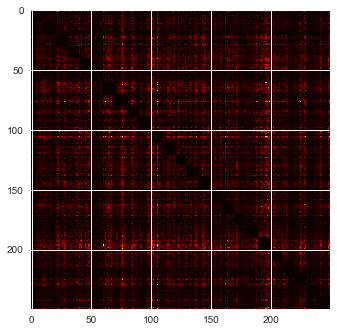

In [572]:
plt.imshow(co_oc_mat_norm, cmap='hot', interpolation='nearest')
plt.show()

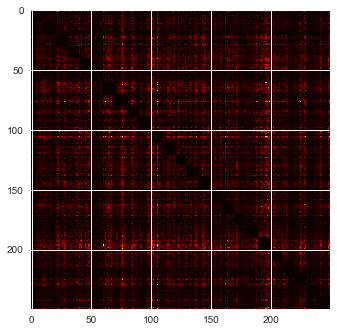

In [573]:
plt.imshow( co_oc_mat , cmap = 'hot' , interpolation = 'nearest' )
plt.show()

In [574]:
prediction_index = pd.read_parquet(f"{path}/prediction_index.parquet")
prediction_index.head()

,week,customer,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4


<br> 

## Reminder

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/time-split.png" width="900"/>

## Some first steps

In [575]:
baskets.week.max()

89

In [576]:
n_weeks = baskets.week.nunique()
print(n_weeks)

90


In [577]:
(
    baskets[(baskets["customer"]==0) & (baskets["product"]==4)]
    .week.count()
    / n_weeks
)

0.08888888888888889

In [578]:
# this is our first "model" – wow, that's easy
purchase_frequency_ij = (
    (
        baskets.groupby(["customer", "product"])
        [["week"]].count()
        / n_weeks
    )
    .rename(columns={"week": "probability"})
    .reset_index()
)
purchase_frequency_ij

,customer,product,probability
0,0,4,0.088889
1,0,11,0.100000
2,0,15,0.011111
3,0,16,0.044444
4,0,21,0.011111
...,...,...,...
142059,1999,237,0.044444
142060,1999,242,0.388889
142061,1999,243,0.011111
142062,1999,245,0.133333


In [579]:
test_week

90

In [580]:
# add all missing values
# Q1: what values are missing?
# Q2: what is a good value for probabilities here?
df = pd.DataFrame(
    {
        "week": test_week,
        "customer": np.repeat(target_customers, len(target_products), axis=0),
        "product": target_products * len(target_customers),
    }
)
df

,week,customer,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4
...,...,...,...
499995,90,1999,245
499996,90,1999,246
499997,90,1999,247
499998,90,1999,248


In [581]:
result_baseline = pd.merge(
    df,
    purchase_frequency_ij,
    on=["customer", "product"],
    how="left",
).fillna(0)
result_baseline

,week,customer,product,probability
0,90,0,0,0.000000
1,90,0,1,0.000000
2,90,0,2,0.000000
3,90,0,3,0.000000
4,90,0,4,0.088889
...,...,...,...,...
499995,90,1999,245,0.133333
499996,90,1999,246,0.000000
499997,90,1999,247,0.000000
499998,90,1999,248,0.000000


<br>

## SOLUTION 1: Descriptive feature (past purchase rates) = Baseline

Now we have predictions, but we have no idea how good this baseline is.  So let's do the following:
1. construct a ground truth data set
1. do a proper train/validation split
1. predict purchase probabilities using our baseline
1. evaluate the predictions vs. the base

### Validation

In [582]:
# function to define target variable for all customer-product combinations (in a given week)
def build_target(baskets, week):

    baskets_week = baskets[baskets["week"] == week][
        ["week", "customer", "product"]
    ].reset_index(drop=True)
    baskets_week["y"] = 1

    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    df = df.merge(baskets_week, on=["week", "customer", "product"], how="left")
    df["y"] = df["y"].fillna(0).astype(int)

    return df

In [583]:
validation_week

89

In [584]:
baseline_target = build_target(baskets, validation_week)
baseline_target.head()

,week,customer,product,y
0,89,0,0,0
1,89,0,1,0
2,89,0,2,0
3,89,0,3,0
4,89,0,4,0


In [585]:
baseline_target.describe()

,week,customer,product,y
count,500000.0,500000.000000,500000.000000,500000.000000
mean,89.0,999.500000,124.500000,0.030386
std,0.0,577.350774,72.168278,0.171647
min,89.0,0.000000,0.000000,0.000000
25%,89.0,499.750000,62.000000,0.000000
50%,89.0,999.500000,124.500000,0.000000
75%,89.0,1499.250000,187.000000,0.000000
max,89.0,1999.000000,249.000000,1.000000


In [586]:
# the perfect prediction has a loss of 0
score_yp(baseline_target.y.values, baseline_target.y.values)

9.99200722162641e-16

In [587]:
# wrap code into function:
# baseline = purchase rates for customer-product combinations before the target week
def baseline_prediction(baskets, week):

    # subset baskets
    baskets_t = baskets[baskets["week"] < week].reset_index(drop=True)
    n_weeks = baskets_t.week.nunique()
    print(n_weeks)

    # model (non-0 probabilities)
    purchase_frequency_ij = (
        (baskets_t.groupby(["customer", "product"])[["week"]].count() / n_weeks)
        .rename(columns={"week": "probability"})
        .reset_index()
    )

    # filling in 0s
    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    result_baseline = pd.merge(
        df,
        purchase_frequency_ij,
        on=["customer", "product"],
        how="left",
    ).fillna(0)

    return result_baseline

In [588]:
# prediction for validation data
baseline_validation = baseline_prediction(baskets, validation_week)
baseline_validation.head()

89


,week,customer,product,probability
0,89,0,0,0.000000
1,89,0,1,0.000000
2,89,0,2,0.000000
3,89,0,3,0.000000
4,89,0,4,0.089888


In [589]:
baseline_target

,week,customer,product,y
0,89,0,0,0
1,89,0,1,0
2,89,0,2,0
3,89,0,3,0
4,89,0,4,0
...,...,...,...,...
499995,89,1999,245,1
499996,89,1999,246,0
499997,89,1999,247,0
499998,89,1999,248,0


In [590]:
baseline_validation

,week,customer,product,probability
0,89,0,0,0.000000
1,89,0,1,0.000000
2,89,0,2,0.000000
3,89,0,3,0.000000
4,89,0,4,0.089888
...,...,...,...,...
499995,89,1999,245,0.123596
499996,89,1999,246,0.000000
499997,89,1999,247,0.000000
499998,89,1999,248,0.000000


In [591]:
# score for validation data
score(baseline_target, baseline_validation)

0.10034939532139737

### Test

In [592]:
validation_week + 1

90

In [593]:
test_week

90

In [594]:
# prediction for test data
# we can't evaluate this
baseline_test = baseline_prediction(baskets, test_week)
baseline_test.head()

90


,week,customer,product,probability
0,90,0,0,0.000000
1,90,0,1,0.000000
2,90,0,2,0.000000
3,90,0,3,0.000000
4,90,0,4,0.088889


Conclusion:
1. Train model to week 88, evaluate predictions for week 89 with truth data 
1. Predcit week 90, and submit

<br>

## SOLUTION 2: simple machine learning model   

### Example for constructing the features

In [595]:
def build_frequency_feature(baskets, week_start, week_end, feature_name):
    # subset baskets
    baskets_subset = baskets[
        (baskets["week"] >= week_start) & (baskets["week"] <= week_end)
    ]
    print(baskets_subset.week.nunique())

    purchase_frequency_ij = (
        (
            baskets_subset.groupby(["customer", "product"])[["week"]].count()
            / baskets_subset.week.nunique()
        )
        .rename(columns={"week": feature_name})
        .reset_index()
    )

    return purchase_frequency_ij

In [596]:
build_frequency_feature(baskets, -1, training_week - 1, "frequency_full")

88


,customer,product,frequency_full
0,0,4,0.090909
1,0,11,0.102273
2,0,15,0.011364
3,0,16,0.034091
4,0,21,0.011364
...,...,...,...
141147,1999,237,0.045455
141148,1999,242,0.397727
141149,1999,243,0.011364
141150,1999,245,0.125000


### Example for building the base table

In [641]:
def build_base_table(baskets, week):
    # target variable (product purchase)
    # consider using multiple weeks for training! more data might lead to better results.
    # also, different weeks might have different information.
    y = build_target(baskets, week)
    # features
    # note how features are computed on data BEFORE the target week
    x_1 = build_frequency_feature(baskets, -1, week - 1, "frequency_full")
    x_2 = build_frequency_feature(baskets, week - 30, week - 1, "frequency_l30")
    x_3 = build_frequency_feature(baskets, week - 5, week - 1, "frequency_l5")
    base_table_yx = (
        y.merge(x_1, on=["customer", "product"], how="left")
        .merge(x_2, on=["customer", "product"], how="left")
        .merge(x_3, on=["customer", "product"], how="left")
        .fillna(0)
    )
    return base_table_yx

In [642]:
build_base_table(baskets, training_week)

88
30
5


,week,customer,product,y,frequency_full,frequency_l30,frequency_l5
0,88,0,0,0,0.000000,0.000000,0.0
1,88,0,1,0,0.000000,0.000000,0.0
2,88,0,2,0,0.000000,0.000000,0.0
3,88,0,3,0,0.000000,0.000000,0.0
4,88,0,4,0,0.090909,0.100000,0.0
...,...,...,...,...,...,...,...
499995,88,1999,245,0,0.125000,0.133333,0.0
499996,88,1999,246,0,0.000000,0.000000,0.0
499997,88,1999,247,0,0.000000,0.000000,0.0
499998,88,1999,248,0,0.000000,0.000000,0.0


### Training: Train model (week < 89)

In [643]:
base_table_train = build_base_table(baskets, training_week)

88
30
5


In [644]:
y = base_table_train["y"].values  # 1s and 0s

In [645]:
X = base_table_train[["frequency_full", "frequency_l30", "frequency_l5"]].values  # purchase frequencies

In [646]:
# Logistic Regression

In [647]:
log_reg = sklearn.linear_model.LogisticRegression().fit(X, y)

In [648]:
log_reg.intercept_, log_reg.coef_

(array([-4.48545291]), array([[10.74680489,  0.30805447, -0.98091252]]))

In [649]:
base_table_train["probability"] = log_reg.predict_proba(X)[:, 1]

In [650]:
score_yp(
    base_table_train["y"].values,
    base_table_train["probability"].values,
)

0.09008063416504795

In [651]:
print(mean_absolute_error(base_table_train["y"].values, base_table_train["probability"].values))
print(mean_squared_error(base_table_train["y"].values, base_table_train["probability"].values))
print(r2_score(base_table_train["y"].values, base_table_train["probability"].values))

0.04315700488184254
0.022914788074339738
0.2288304561136496


In [652]:
# Random Forest

In [653]:
rf = sklearn.ensemble.RandomForestClassifier().fit(X, y)

In [654]:
base_table_train["probability"] = rf.predict_proba(X)[:, 1]

In [655]:
score_yp(
    base_table_train["y"].values,
    base_table_train["probability"].values,
)

0.07490377788281079

In [656]:
print(mean_absolute_error(base_table_train["y"].values, base_table_train["probability"].values))
print(mean_squared_error(base_table_train["y"].values, base_table_train["probability"].values))
print(r2_score(base_table_train["y"].values, base_table_train["probability"].values))

0.041260258866535705
0.020550512198264547
0.30839730801118526


In [657]:
# Boosted Trees

In [658]:
boost_tr = sklearn.ensemble.GradientBoostingClassifier().fit(X, y)
X

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.09090909, 0.        , 0.        ]])

In [659]:
base_table_train["probability"] = boost_tr.predict_proba(X)[:, 1]

In [660]:
score_yp(
    base_table_train["y"].values,
    base_table_train["probability"].values,
)

0.07752181997123096

In [661]:
print(mean_absolute_error(base_table_train["y"].values, base_table_train["probability"].values))
print(mean_squared_error(base_table_train["y"].values, base_table_train["probability"].values))
print(r2_score(base_table_train["y"].values, base_table_train["probability"].values))

0.04307403389317016
0.021498388072914095
0.27649768914746464


### Validation: Test model performance (week 89)

In [662]:
base_table_validation = build_base_table(baskets, validation_week)

89
30
5


In [663]:
X_validation = base_table_validation[
    ["frequency_full", "frequency_l30", "frequency_l5"]
].values

In [664]:
# Logistic Regression

In [665]:
base_table_validation["probability"] = log_reg.predict_proba(X_validation)[:, 1]

In [666]:
score_yp(
    base_table_validation["y"].values,
    base_table_validation["probability"].values,
)

0.08962234697918602

In [667]:
print(mean_absolute_error(base_table_validation["y"].values, base_table_validation["probability"].values))
print(mean_squared_error(base_table_validation["y"].values, base_table_validation["probability"].values))
print(r2_score(base_table_validation["y"].values, base_table_validation["probability"].values))

0.043041289767999015
0.022802397878428783
0.22605854722051644


In [668]:
# Random Forest

In [669]:
base_table_validation["probability"] = rf.predict_proba(X_validation)[:, 1]

In [670]:
score_yp(
    base_table_validation["y"].values,
    base_table_validation["probability"].values,
)

0.08790153546254012

In [671]:
print(mean_absolute_error(base_table_validation["y"].values, base_table_validation["probability"].values))
print(mean_squared_error(base_table_validation["y"].values, base_table_validation["probability"].values))
print(r2_score(base_table_validation["y"].values, base_table_validation["probability"].values))

0.04297349865374495
0.022233562835750845
0.2453655087808405


In [672]:
# Boosted Trees

In [673]:
base_table_validation["probability"] = boost_tr.predict_proba(X_validation)[:, 1]

In [674]:
score_yp(
    base_table_validation["y"].values,
    base_table_validation["probability"].values,
)

0.07712281180815277

In [675]:
print(mean_absolute_error(base_table_validation["y"].values, base_table_validation["probability"].values))
print(mean_squared_error(base_table_validation["y"].values, base_table_validation["probability"].values))
print(r2_score(base_table_validation["y"].values, base_table_validation["probability"].values))
print(boost_tr.aic)

0.04319986823232003
0.02146063368809061
0.2715996754954594


AttributeError: 'GradientBoostingClassifier' object has no attribute 'aic'

### Test: Produce final result (week 90) - not for us

In [331]:
base_table_test = build_base_table(baskets, test_week)

90
30
5


In [332]:
X_test = base_table_test[["frequency_full", "frequency_l30", "frequency_l5"]].values

In [333]:
base_table_test["probability"] = log_reg.predict_proba(X_test)[:, 1]

In [338]:
score_yp(
    base_table_test["y"].values,
    base_table_test["probability"].values,
)

ValueError: y_true contains only one label (0). Please provide the true labels explicitly through the labels argument.

<br>

## Score on test set

In real life, never load your test/validation data durnig model training!

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/danger-zone.gif" width="700"/>

In [341]:
# true purchases in week 90
truth = pd.read_parquet(f"{path_truth}/truth.parquet") #before
# truth = pd.read_parquet(f"{path_truth}//baskets-s.parquet")
truth


,week,customer,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592
...,...,...,...,...
68091869,89,1999,144,562
68091870,89,1999,158,566
68091871,89,1999,192,549
68091872,89,1999,213,592


In [342]:
score(truth, baseline_test)

AssertionError: 

In [343]:
score(
    truth,
    base_table_test[["customer", "product", "week", "probability"]],
)

AssertionError: 

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
`Learning from Big Data`, Module 2, Extra Tutorial <br>
2021/22 <br>